### Goal

To replicate John Shewchuck's ice core temperature chart (which is data from an Antartic ice core).

Status:  perfectly replicated

### To do

The chart replicated was data from an Antartic ice core even though the video extols a corroborating result from data collected in North Greenland (the N in NEEM).

Find and analyze the NEEM data.

### Inspiration

https://www.youtube.com/watch?v=folh5yyFyl8

This video highlights the NEEM Project which shows the Earth was way hotter than it is today about 120,000 years ago...during the Eemain period.

### Source Data

Two, corroborating sources:
1) Pangaea: https://doi.pangaea.de/10.1594/PANGAEA.683655?format=textfile
2) NOAA: https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc3deuttemp2007.txt

In [1]:
import polars as pl
import matplotlib.pyplot as plt

pl.Config.set_tbl_rows(6)

polars.config.Config

### Process NOAA source data

In [14]:
input_file = 'source-data/epica-dome-c-ice-core/edc3deuttemp2007.txt'

# Read the data from the file
data = []
with open(input_file, 'r') as file:
    # Skip the first 91 comment lines
    for _ in range(91):
        next(file)
    
    # Skip the header line
    next(file)

    # Process the data meat
    for line in file:
        # Split the line by whitespace and strip any extra spaces
        parts = line.strip().split()
        
        # Convert to appropriate types and handle missing values
        bag = int(parts[0]) if len(parts) > 0 else None
        ztop = float(parts[1]) if len(parts) > 1 else None
        age = float(parts[2]) if len(parts) > 2 else None
        deuterium = float(parts[3]) if len(parts) > 3 else None
        temperature = float(parts[4]) if len(parts) > 4 else None
        
        # Append the processed data to the list
        if len(parts) > 0:
            data.append([bag, ztop, age, deuterium, temperature])

In [15]:
noaa = (
    pl.dataframe.DataFrame(data, schema=['bag', 'ztop', 'age', 'deuterium', 'delta'], orient='row')
    .with_columns(
        (pl.col('age') / 1000).alias('ka'),
    )
    .sort('age', descending=True)
    .filter(
        pl.col('ka') <= 500,
        pl.col('delta').is_not_null(),
    )
)

### Process Pangaea source data

In [17]:
pangaea = (
    pl.read_csv(
        'source-data/epica-dome-c-ice-core/EDC_dD_temp_estim.tab',
        separator='\t',
        skip_lines=20
    )
    .with_columns(
        pl.col('Age model [ka]').alias('ka'),
        pl.col('delta T [°C]').alias('delta'),
    )
    .sort('ka', descending=True)
    .filter(
        pl.col('ka') <= 500,
        pl.col('delta').is_not_null(),
    )
)

### Make the chart

In [27]:
def replicate_chart(x, y, source):
    # Plot the data
    plt.figure(figsize=(11, 4))
    plt.plot(x, y, color='red', label='Deltas', linewidth=1)
    plt.title(f'Ice Age Temperatures\n{source}')
    plt.gca().invert_xaxis()
    plt.xlabel('Thousands of Years before present (ka)')
    plt.ylabel('Delta in °C\n(relative to average of last 1000 years)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

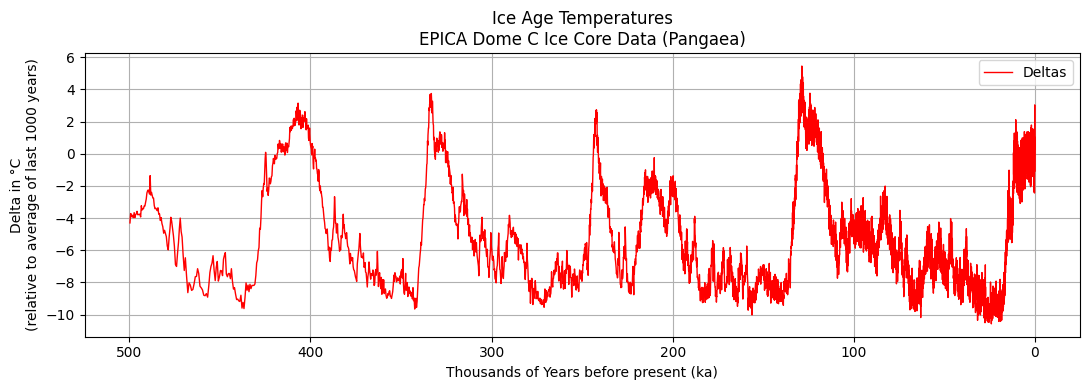

In [28]:
replicate_chart(pangaea['ka'], pangaea['delta'], 'EPICA Dome C Ice Core Data (Pangaea)')

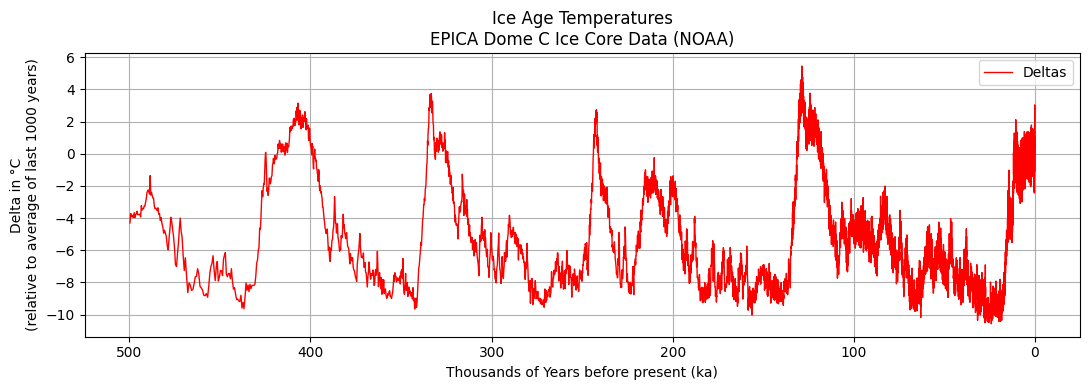

In [29]:
replicate_chart(noaa['ka'], noaa['delta'], 'EPICA Dome C Ice Core Data (NOAA)')